# Functions, classes, libraries

In [11]:
#------------------------------------------------------------------
# TEST SUPER RESOLUTION IMAGES
#------------------------------------------------------------------
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import os, cv2
import numpy as np
import pydicom as dicom
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#---------------------
from test import test 
from unet_3block_conv import *
from outils_prepro import * 
from data_loader_seg import *
from model_prob_unet_init import *
from create_images_3_classes import *
from training import *
from loss import *
from model_SR_center_line import *   

In [12]:
from torch.utils.data import Dataset
import cv2
import torch 
import numpy as np

class Segmentation_CT_Dataset_multi(Dataset):
    def __init__(self, imageList, image_shape, transforms = None):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imageList = imageList
        self.transforms = transforms
        self.image_shape =  image_shape
    def __len__(self):
        return len(self.imageList)

    def _get_tensor_image_(self, image):
        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed["image"]
        return image
    def __getitem__(self, idx):
        # grab the image path from the current index
        # t, t+1, t-1 
        image_t  = self._get_tensor_image_(self.imageList[idx][0])
        image_after  = self._get_tensor_image_(self.imageList[idx][1])
        image_before  = self._get_tensor_image_(self.imageList[idx][2])

        return image_t, image_after, image_before




In [13]:
import torch
from torch import nn
class UNET_multi(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def forward(self, t, af, be):
        x = torch.cat((be, t, af), 1) 
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
    
  

In [14]:
import torch
from torch import nn

def test_SR_UNET(net, dataloaders_test, device, multi=False):
    seg_sr_images = []
    for _, batch in enumerate(dataloaders_test): 
        if multi:
            X, X_af, X_be = batch
            X, X_af, X_be = X.to(device), X_af.to(device), X_be.to(device)
            pred = net(X, X_af, X_be)
        else:
            X = batch
            X  = X.to(device)
            pred = net(X)

        seg = torch.argmax(pred, dim=1).numpy()[0]
        seg_sr_images.append(seg)# torch.argmax(pred, 1).numpy())
    return seg_sr_images    
  
  #------------------------------------------------


In [172]:
def SR_CT(path, list_img):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(path)
    sr.setModel("lapsrn",8)
    sr_image =[]
    for img in list_img:
        image  = img.astype(np.float32)*255
        final_img = cv2.merge([image,image,image])
        sr_image.append(sr.upsample(final_img)/255)
    return sr_image


# Function to take care of teh translation and windowing. 
def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale: 
        img = (img - img_min) / (img_max - img_min)*255.0 
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == dicom.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]



def read_center_line(datos, error, dirr):
    folder_ct = 'data_ct'
    ct_im = []
    ct_im_w = []
    boxes  = []
    files = os.listdir(os.path.join(dirr, folder_ct)) 
    files.sort()
    print(np.max(datos['Slice']), np.min(datos['Slice']))
    files = files[np.min(datos['Slice']) -1:np.max(datos['Slice'])]
    for i, file in enumerate(files):
        image_ = dicom.dcmread(os.path.join(dirr,folder_ct, file))
        window_center , window_width, intercept, slope = get_windowing(image_)
        output = window_image(image_.pixel_array, window_center, window_width, intercept, slope, rescale = False)
    
        x , y = datos['px'][i].astype('int'), datos['py'][i].astype('int')
        ct_im_w.append(output)
        ct_im.append(image_.pixel_array)
        # x1,w1, y1 , h1 = x - error, x + error,  y - error, y + error
        # ct_im_w.append(output[y1:h1, x1:w1])
        # ct_im.append(image_.pixel_array[y1:h1, x1:w1])
        boxes.append([x, y])
        i += 1
    return ct_im, ct_im_w, boxes

def cut_calc_images(list_images, boxes_list, error):
    cut_images = []
    for image, box in zip(list_images, boxes_list):
        x,y = box
        x1,w1, y1 , h1 = x - error, x + error,  y - error, y + error
        cut_images.append(image[y1:h1, x1:w1])
    return cut_images


def min_max_norm(im_list, all_DATA = False):
    max_list = [np.max(im) for im in im_list]
    min_list  = [np.min(im) for im in im_list]
    max_v = np.max(max_list)
    min_v = np.min(min_list)
    print('Min Max all data set',max_v , min_v)
    if all_DATA:
        im_list_norm = [ (im-  min_v)/(max_v -  min_v) for im in im_list]
        print('Normalization wrt all data set')
    else:
        im_list_norm = [ (im_list[k]-  min_list[k])/(max_list[k] -  min_list[k]) for k in range(len(im_list))]
        print('Normalization wrt each image')

    max_v  = np.max([np.max(im) for im in im_list_norm])
    min_v  = np.min([np.min(im) for im in im_list_norm])
    print('Min Max after normalization all data set',max_v , min_v)
    return im_list_norm


def change_values_CT_calc(image, info_change, new_min = None):
    ''' 
    LB: Lower bound lumen
    UB: Upper bound lumen
    Lvalue: Lower value to reemplace the image 
    Uvalue: Upper value to reemplace the image
    '''

    voisinage, LB, UB, Lvalue, Uvalue, n_voisins = info_change
    image = np.pad(image, 1, mode='constant', constant_values=0)
    values = np.where((image >=LB) & (image <=UB))

    voisinage  = 4
    if voisinage == 4:
        neigh_table = [(0, -1), (-1, 0), (0, 1), (1, 0)]
    elif voisinage == 8:
        neigh_table = [(0, -1), (-1, 0), (0, 1), (1, 0), (-1, -1), (1, -1),
        (-1, 1), (1, 1)]

    l1 = []
    l2 = []
    for i in range(len(values[0])):
        aux = 0
        for v in neigh_table:
            aux += 1*((image[values[0][i] + v[0], values[1][i]  + v[1]]>=LB) & (image[values[0][i] + v[0], values[1][i]  + v[1]]<=UB))
        if aux >=n_voisins:
            l1.append(values[0][i])
            l2.append(values[1][i])

    image[(l1, l2)] =  np.random.randint(Lvalue,Uvalue, len(l1))  
    image = image[1:image.shape[0]-1, 1:image.shape[0]-1]

    if new_min!= None:
        image[np.where(image <=0 )] = new_min
        
    return image



def run_center_line(dirr, sheet, error, info_change, norm_ALL = False, new_min = None):    
    path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
    path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
    file = 'datos_info.xlsx'
    datos = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
    #------------------------------------------------
    ct_im_, ct_im_w_, boxes = read_center_line(datos, error, dirr)
    max_v = np.max([np.max(im) for im in ct_im_])
    min_v  = np.min([np.min(im) for im in ct_im_])
 
    ct_im = cut_calc_images(ct_im_, boxes, error)
    

    ct_im_aux = [change_values_CT_calc(image, info_change, new_min) for image in ct_im]
    
    #ct_change_norm = [ (im-  min_v)/(max_v -  min_v) for im in ct_im_aux] 
    
    ct_change_norm = min_max_norm(ct_im_aux, all_DATA = norm_ALL)
    
    # ct_im_norm = cut_calc_images(min_max_norm(ct_im_, all_DATA = norm_ALL), boxes, error)
    # ct_im_norm_w = cut_calc_images(min_max_norm(ct_im_w_, all_DATA = norm_ALL), boxes, error)

    sr_images = SR_CT(path_sr, ct_change_norm)
    
    # ct_im_w = cut_calc_images(ct_im_w_, boxes, error)
    # ct_change_norm_w = min_max_norm([change_values_CT_calc(image, info_change) for image in ct_im_w], all_DATA = norm_ALL)
    # sr_images_w = SR_CT(path_sr, ct_change_norm_w)
    
    return sr_images, ct_im, ct_change_norm,  ct_im_aux


def test_center_line(sr_images, multi_, n_classes, folder_name, epoch_init):
    #---------------------
    # Data
    batch_size_test  = 1
    image_shape = sr_images[0].shape[0:2]#(64, 64) 
    #---------------------- 
    
    if multi_:
        print('MULTI')
        image_list  = [ [sr_images[i],sr_images[i+1],sr_images[i-1]]  for i in np.arange(1,len(sr_images)-1)] 
        
        data_test = Segmentation_CT_Dataset_multi(image_list,image_shape)
        dataloaders_test = torch.utils.data.DataLoader(data_test, batch_size_test)
        #----------------------
        # Model 
        input_channels = 9
        num_classes = n_classes
        net = UNET_multi(input_channels, num_classes) 
    else: 
        print('1 INPUT')
        image_list  = [ [sr_images[i],sr_images[i+1],sr_images[i-1]]  for i in np.arange(1,len(sr_images)-1)] 
        
        data_test = Segmentation_CT_Dataset(sr_images,image_shape)
        dataloaders_test = torch.utils.data.DataLoader(data_test, batch_size_test)
        #----------------------
        # Model 
        input_channels = 3
        num_classes =  n_classes
        net = UNET(input_channels, num_classes) 


    #----------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
    net.to(device)
    net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init)))
    net.eval()
    seg_sr_images = test_SR_UNET(net, dataloaders_test, device, multi= multi_)
    return seg_sr_images


In [145]:
def plot_SR_segmentations(seg_sr_images, datos, size = (25,180)):
    fig = plt.figure(figsize=size)
    j = len(seg_sr_images)//6
    k = 0
    h = 0
    channel = 0
    for i in range(k,k+j):
        ax  =  plt.subplot(j, 6, 6*h+1)
        ax.imshow(seg_sr_images[6*i][:,:,channel])
        ax.set_title(" CT  "+str(datos['Slice'][6*i]))
        
        ax  =  plt.subplot(j, 6, 6*h+2)
        ax.imshow(seg_sr_images[6*i+1][:,:,channel])
        ax.set_title("CT  "+str(datos['Slice'][6*i+1]))
        
        ax  =  plt.subplot(j, 6, 6*h+3)
        ax.imshow(seg_sr_images[6*i+2][:,:,channel])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+2]))
        
        ax  =  plt.subplot(j, 6, 6*h+4)
        ax.imshow(seg_sr_images[6*i+3][:,:,channel])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+3]))  

        ax  =  plt.subplot(j, 6, 6*h+5)
        ax.imshow(seg_sr_images[6*i+4][:,:,channel])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+4]))  

        ax  =  plt.subplot(j, 6, 6*h+6)
        ax.imshow(seg_sr_images[6*i+5][:,:,channel])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+5]))   
        h +=1

def plot_CT_SR_seg(CT_img,  datos, size = (50,150)):
    j = len(CT_img)//4
    print(j)
    channel = 0
    col = 'black'
    Cmap = ''
    fig, ax  =  plt.subplots(j, 4, figsize=size)
    
    for i in range(j):
        ax[i, 0].imshow(CT_img[4*i])
        ax[i, 0].set_title(" CT  "+str(datos['Slice'][4*i]), color = 'white')
        

        ax[i, 1].imshow(CT_img[4*i+1])
        ax[i, 1].set_title(" CT  "+str(datos['Slice'][4*i+1]),  color = 'white')
        

        ax[i, 2].imshow(CT_img[4*i+2])
        ax[i, 2].set_title(" CT  "+str(datos['Slice'][4*i+2]), color = 'white')
                            
        ax[i, 3].imshow(CT_img[4*i+3])
        ax[i, 3].set_title(" CT  "+str(datos['Slice'][4*i+3]), color = 'white')                    

def add_zeros(image):
    image[0,0] = int(0)
    image[0,1] = int(1)
    image[1,0] = int(2)
    image[1,1] = int(3)
    return image

def img_to_plot(list_img):
    return [add_zeros(image) for image in list_img]

def plot_complete_images(lowRS_, SRimg, seg1_, seg2_, seg3_, seg4_, datos, name, size = (25,280)):
    lowRS = img_to_plot(lowRS_) 
    #SRimg = img_to_plot(SRimg_)
    seg1 = img_to_plot(seg1_)
    seg2 = img_to_plot(seg2_) 
    seg3 = img_to_plot(seg3_)
    seg4 = img_to_plot(seg4_)
    fig = plt.figure(figsize=size)
    j = len(lowRS)
    #j = len(lowRS)//6
    k = 0
    h = 0
    for i in range(k,k+j-2):
        ax  =  plt.subplot(j, 6, 6*h+1)
        ax.imshow(lowRS[i])
        ax.set_title(" Low Resolution "+str(datos['Slice'][i]))
        
        ax  =  plt.subplot(j, 6, 6*h+2)
        ax.imshow(SRimg[i])
        ax.set_title("Super Resolution  "+str(datos['Slice'][i]))
        
        ax  =  plt.subplot(j, 6, 6*h+3)
        ax.imshow(seg1[i])
        ax.set_title(" Seg 1 input "+str(datos['Slice'][i]))
        
        ax  =  plt.subplot(j, 6, 6*h+4)
        ax.imshow(seg2[i])
        ax.set_title(" Seg multi input  "+str(datos['Slice'][i]))  

        ax  =  plt.subplot(j, 6, 6*h+5)
        ax.imshow(seg3[i])
        ax.set_title("Seg MI + More Classes  "+str(datos['Slice'][i]))  

        ax  =  plt.subplot(j, 6, 6*h+6)
        ax.imshow(seg4[i])
        ax.set_title(" Seg MI + MC + SR images Training"+str(datos['Slice'][i]))   
        h +=1
    
    plt.savefig(os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\IMAGES', name))
    plt.close(fig)
    


# SFA006
Slides with calcification: CT 1484 - CT 1496

In [171]:
class UNET_multi(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 8, 7, 3)
        self.conv2 = self.contract_block(8, 32, 3, 1)
        self.conv3 = self.contract_block(32, 64, 3, 1)
        self.conv4 = self.contract_block(64, 128, 3, 1)

        self.upconv4 = self.expand_block(128, 64, 3, 1)
        self.upconv3 = self.expand_block(64*2, 32, 3, 1)
        self.upconv2 = self.expand_block(32*2, 8, 3, 1)
        self.upconv1 = self.expand_block(8*2, out_channels, 3, 1)

    def forward(self, t, af, be):
        x = torch.cat((be, t, af), 1) 
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(p=0.2),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Dropout2d(p=0.2),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
    
  


In [167]:
path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
file = 'datos_info.xlsx'
error = 7
LB = 150
UB = 450
Lvalue = 50
Uvalue = 100
voisinage = 4
n_voisins = 2
norm_ALL = True
new_min = -500
info_change = [voisinage, LB, UB, Lvalue, Uvalue, n_voisins]

dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006'
sheet = 'SR_SFA0006_v1'
datos = pd.read_excel(os.path.join(path, file), sheet_name= sheet)

sr_images, ct_im,  ct_change_norm,  ct_im_new_values = run_center_line(dirr, sheet, error, info_change, norm_ALL = norm_ALL, new_min= new_min)


1588 1361
Min Max all data set 1679 -500
Normalization wrt all data set
Min Max after normalization all data set 1.0 0.0


Slice:  1505


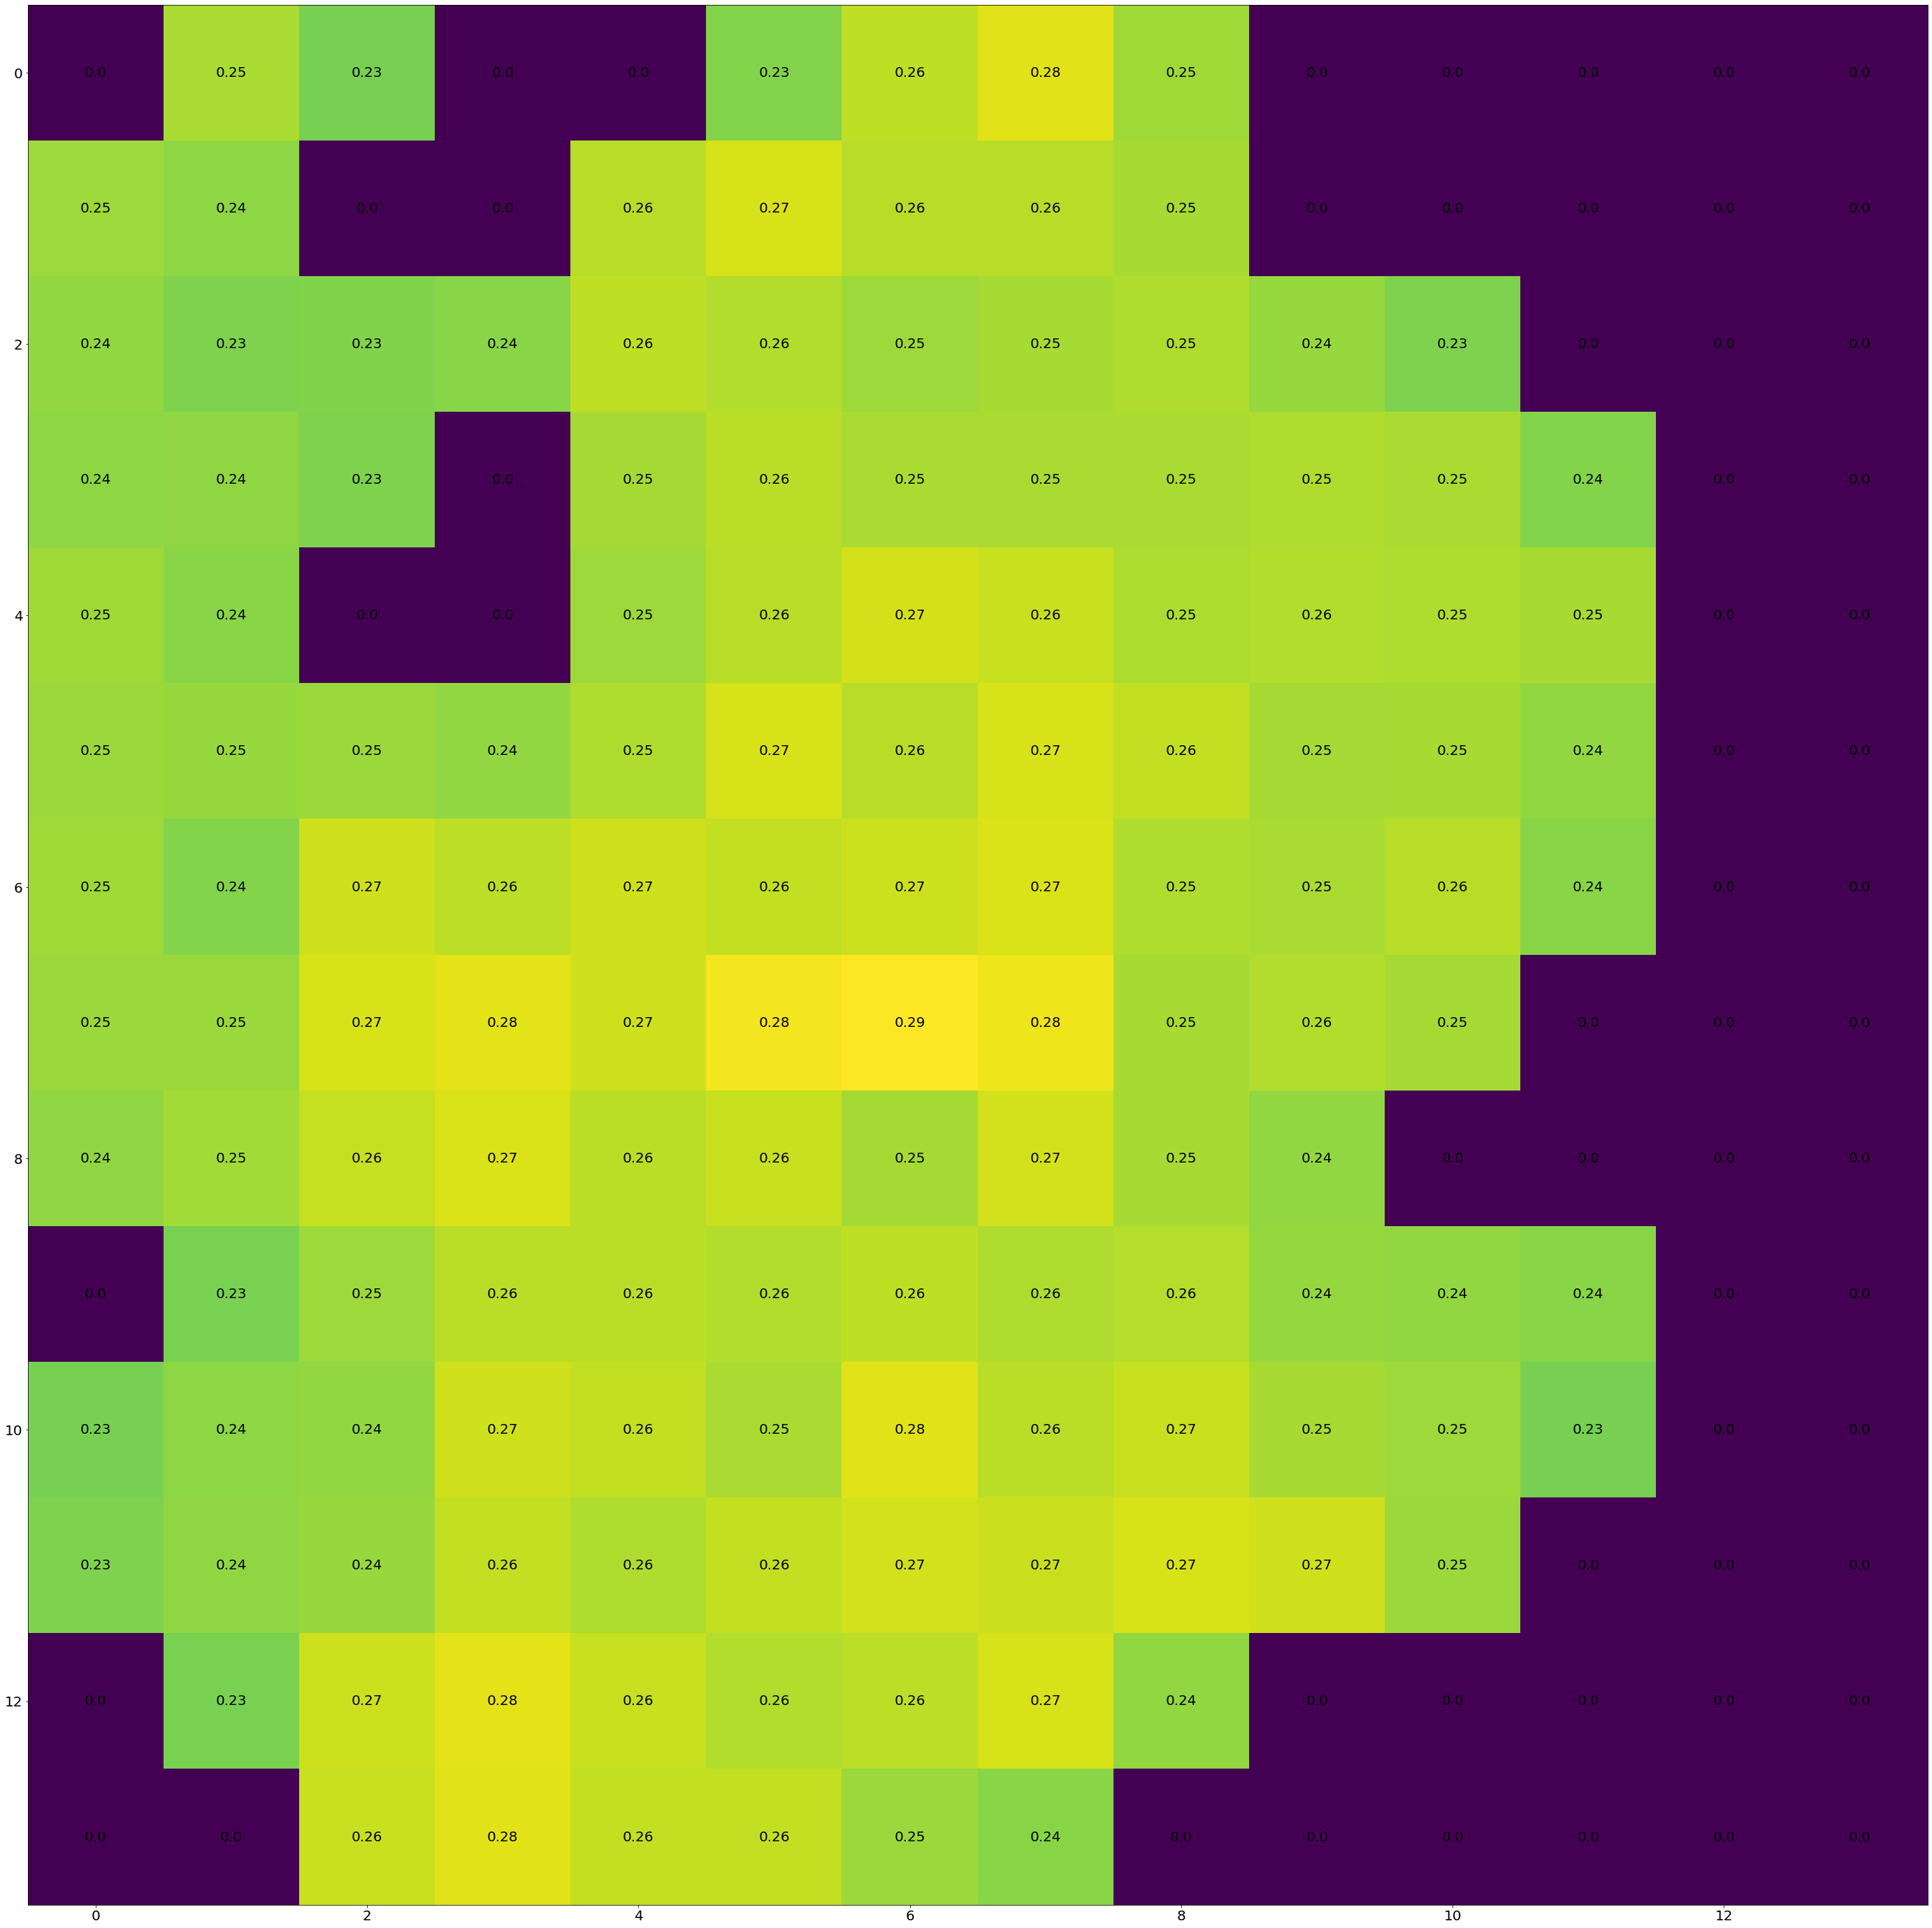

In [156]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
#---------------------------------
index = 144
print('Slice: ', datos.Slice.iloc[index])
#---------------------------------

img = ct_change_norm[index]
fig = plt.figure(figsize=(50,50))
channel = 0
col = 'black'
ax  =  plt.subplot()
ax.imshow(img)
#ax.set_title(" SR CT  "+str(name_list[index]['Slice'][2*i]))
for l in range(img.shape[0]):
    for m in range(img.shape[1]):
        text = ax.text(m, l, str(np.round(img[l, m], 2)),
                    ha="center", va="center", color=col)

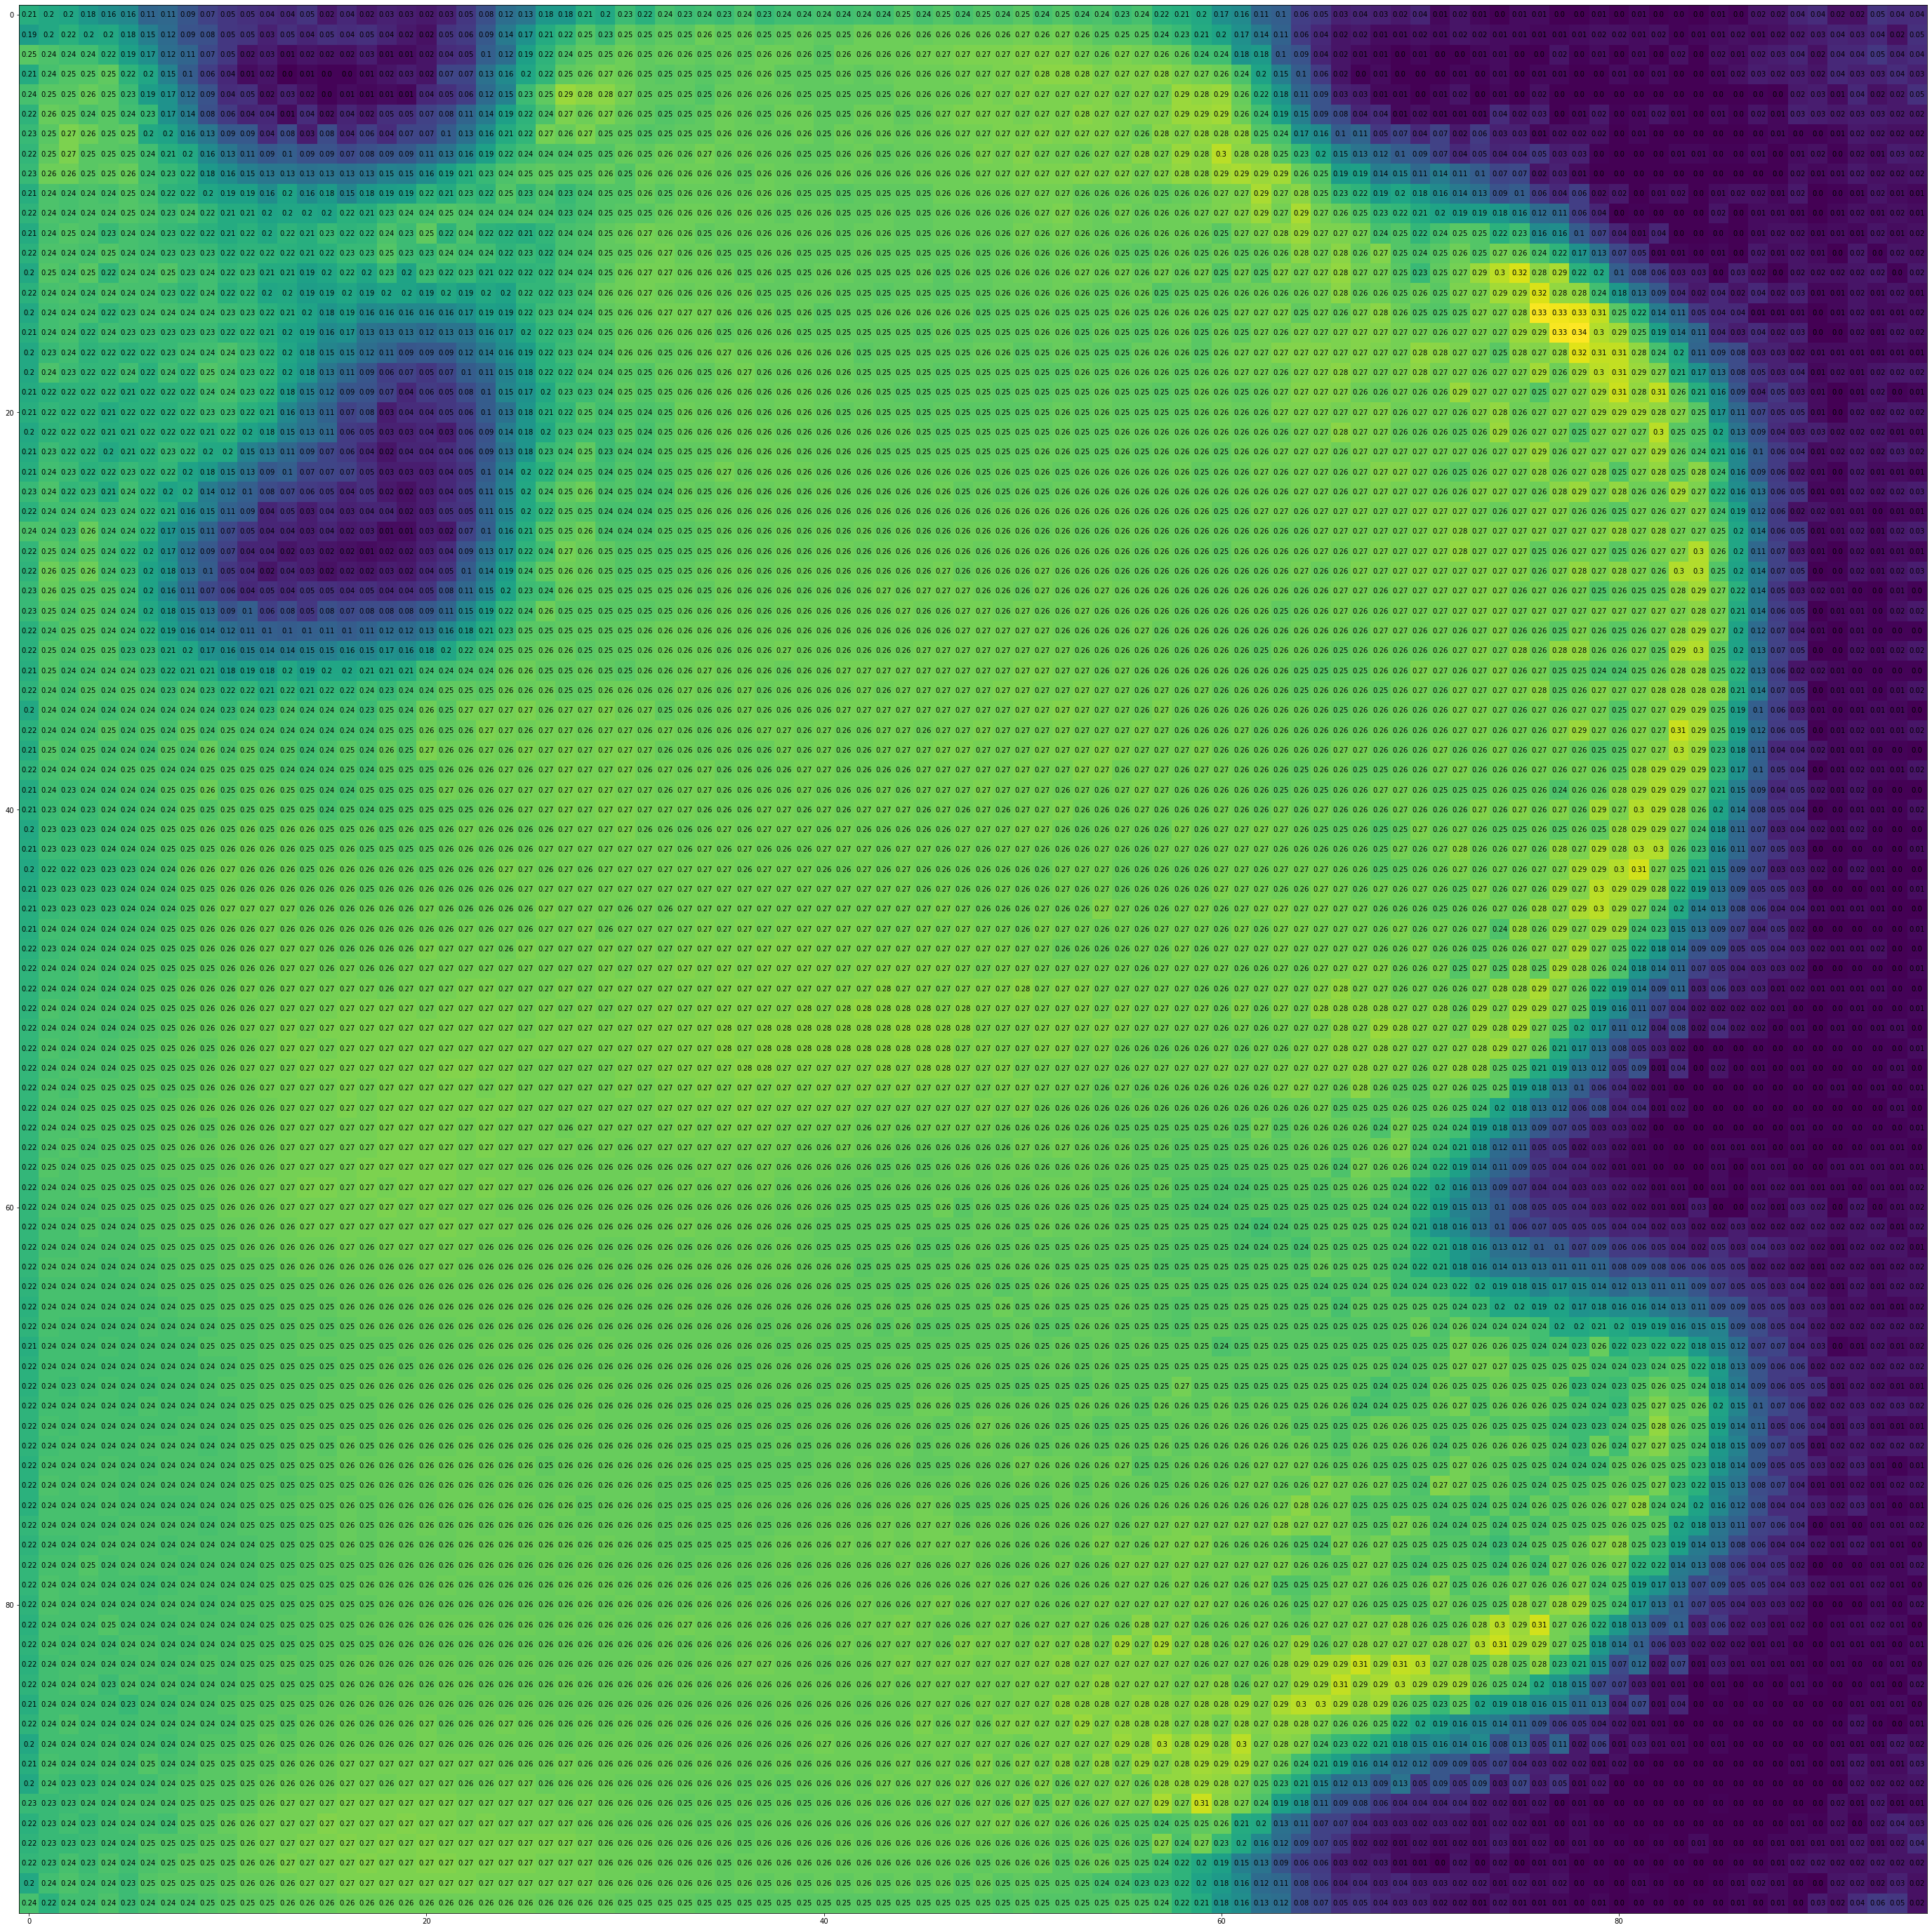

In [144]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

img = sr_images[index]
fig = plt.figure(figsize=(50,50))
channel = 0
col = 'black'
ax  =  plt.subplot()
ax.imshow(img[:,:,channel])
#ax.set_title(" SR CT  "+str(name_list[index]['Slice'][2*i]))
for l in range(img[:,:,channel].shape[0]):
    for m in range(img[:,:,channel].shape[1]):
        text = ax.text(m, l, str(np.round(img[:,:,channel][l, m], 2)),
                    ha="center", va="center", color=col)

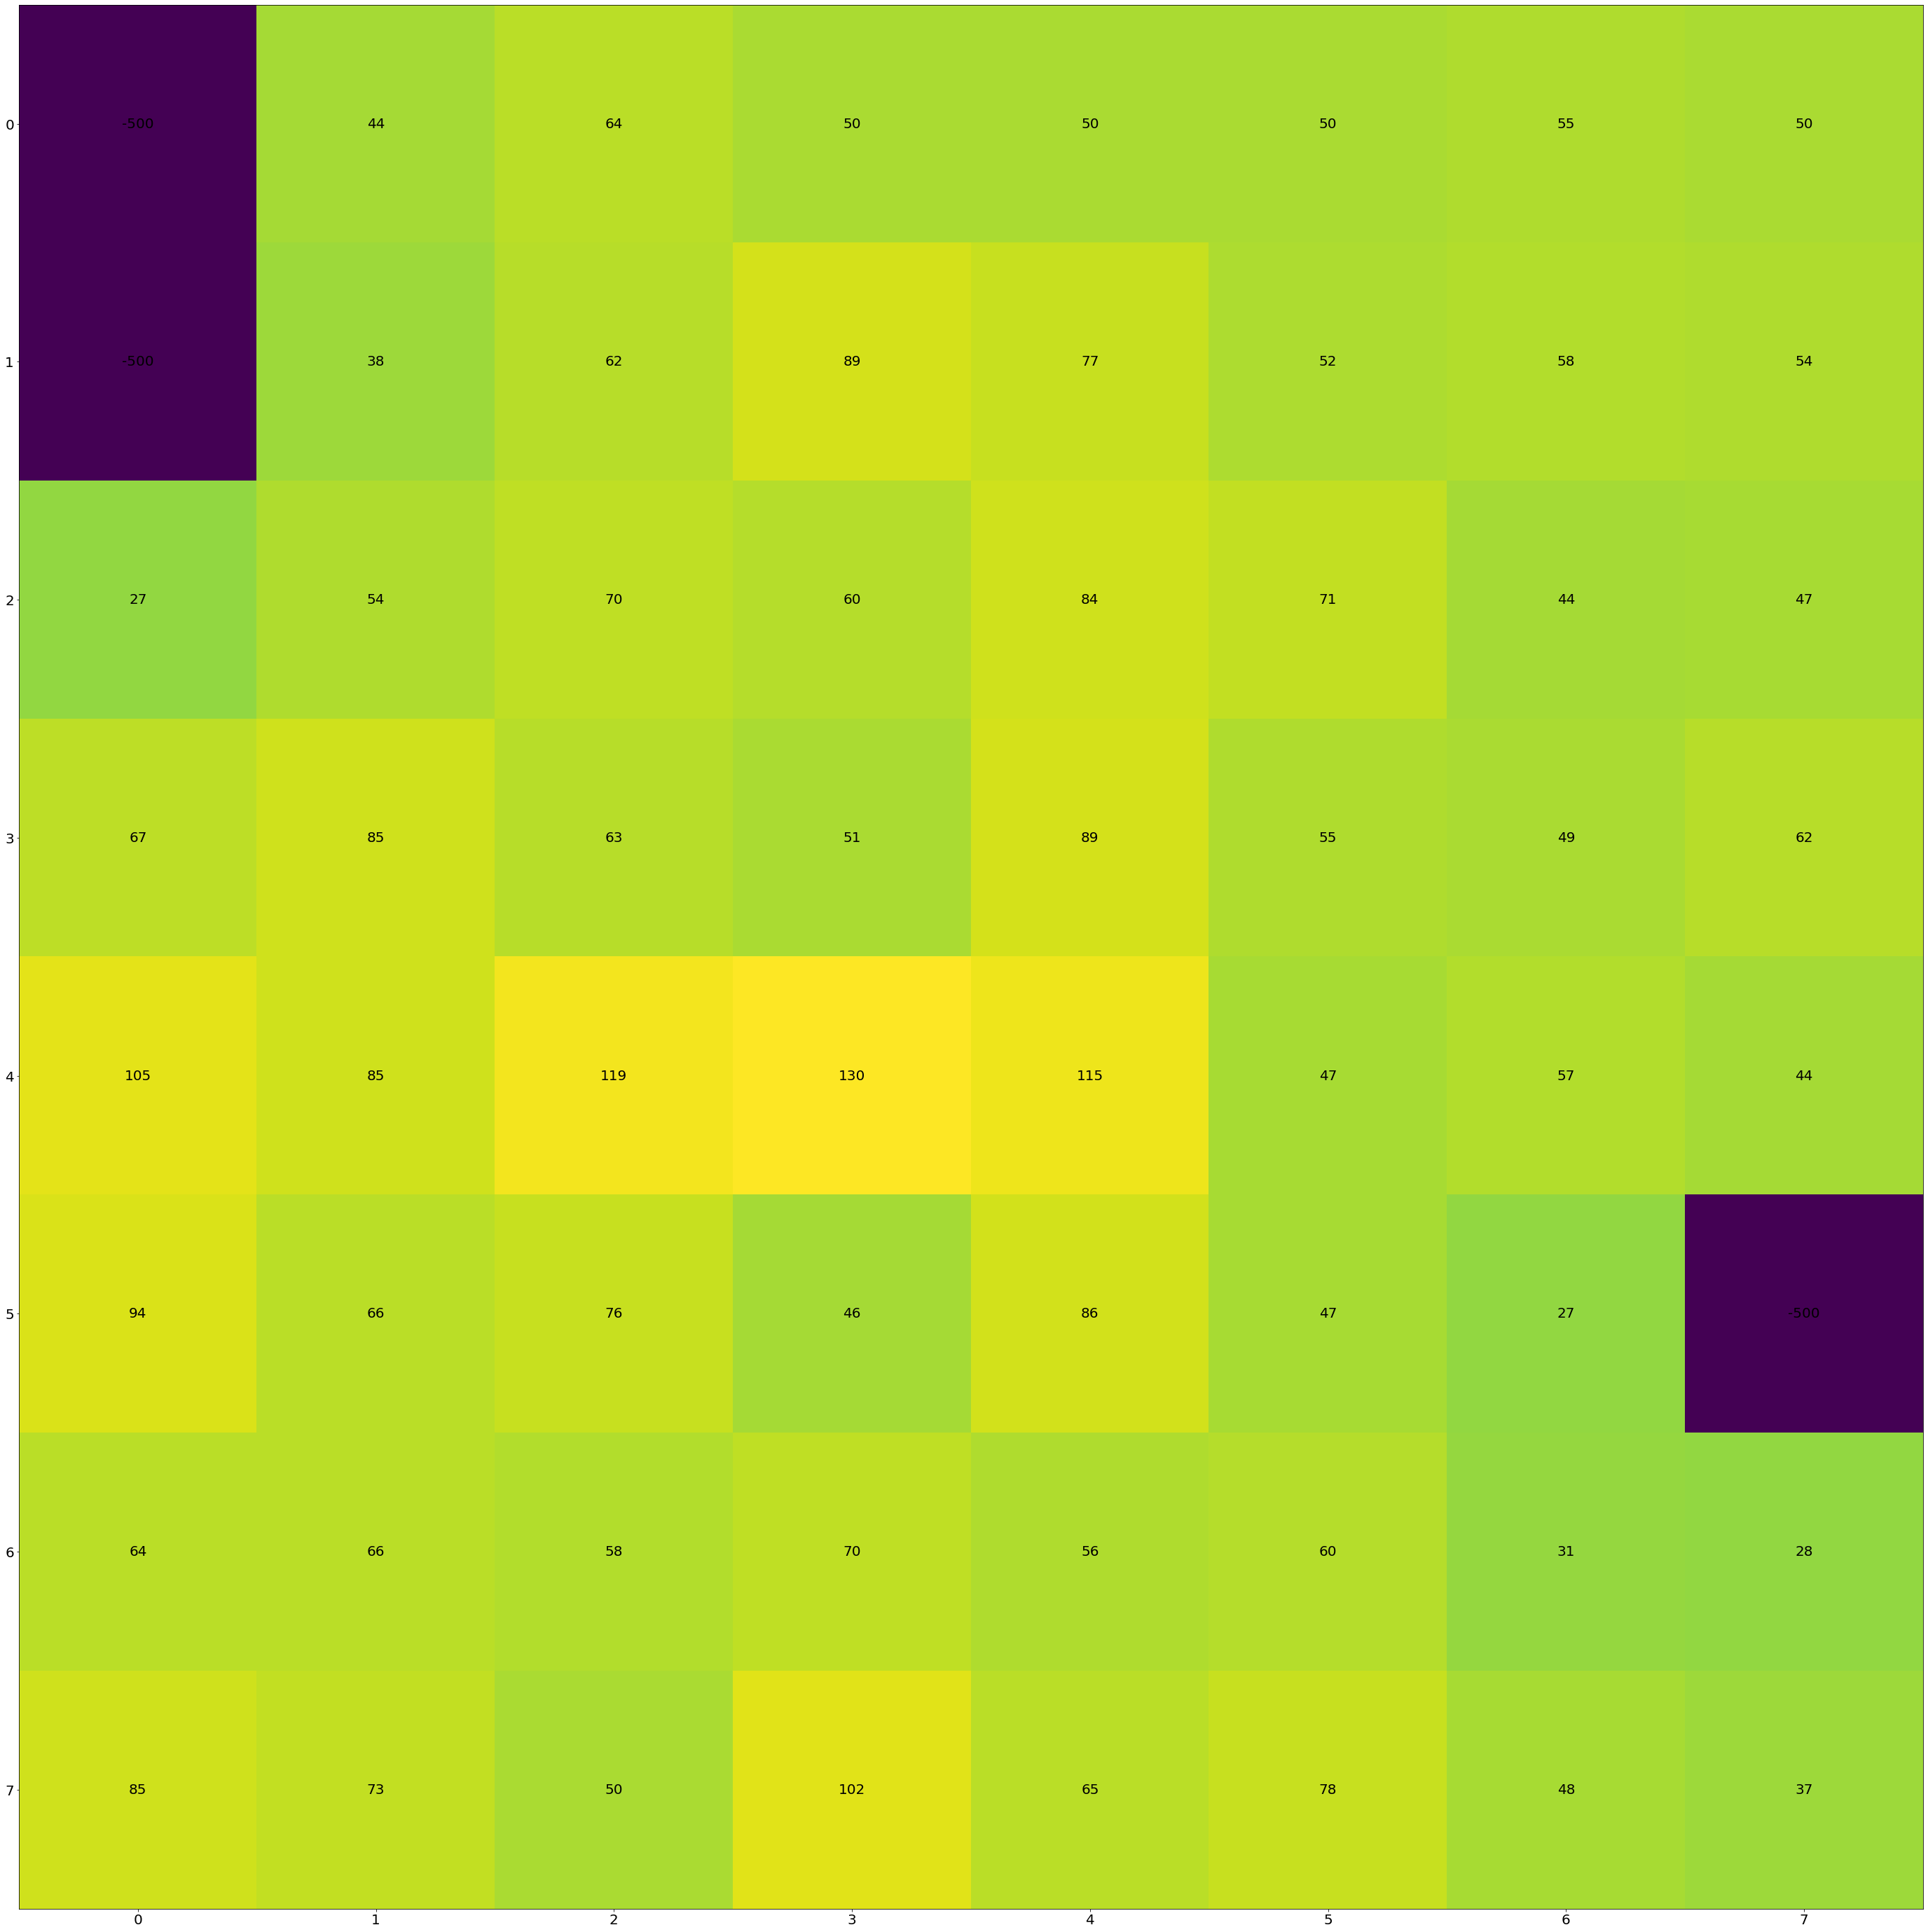

In [148]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

img = ct_im_new_values[index]
fig = plt.figure(figsize=(50,50))
channel = 0
col = 'black'
ax  =  plt.subplot()
ax.imshow(img)
#ax.set_title(" SR CT  "+str(name_list[index]['Slice'][2*i]))
for l in range(img.shape[0]):
    for m in range(img.shape[1]):
        text = ax.text(m, l, str(np.round(img[l, m], 2)),
                    ha="center", va="center", color=col)

## UNET 1 INPUT

In [159]:
n_classes = 3
folder_name = 'model_unet_1'
epoch_init = '100.torch'
multi = False
#------------------------------------------------
seg_sr_images_1input = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

1 INPUT


## UNET MULTI INPUT

In [160]:
#------------------------------------------------
n_classes = 3
folder_name = 'model_unet_multi_3'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_multi_input = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)


MULTI


In [161]:
# #------------------------------------------------
# n_classes = 5
# folder_name = 'model_unet_multi_1_more_classes'
# epoch_init = '100.torch'
# multi = True
# #------------------------------------------------
# seg_sr_images_MI_MC = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)
#------------------------------------------------
n_classes = 4
folder_name = 'model_unet_multi_6_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


In [162]:
#------------------------------------------------
n_classes = 4
folder_name = 'model_unet_multi_5_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC_SR =  test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


In [168]:
#------------------------------------------------
n_classes = 4
folder_name = 'model_unet_multi_5_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC_SR =  test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


In [153]:
# index = 4
# np.unique(seg_sr_images_MI_MC_SR[index])

MULTI
56


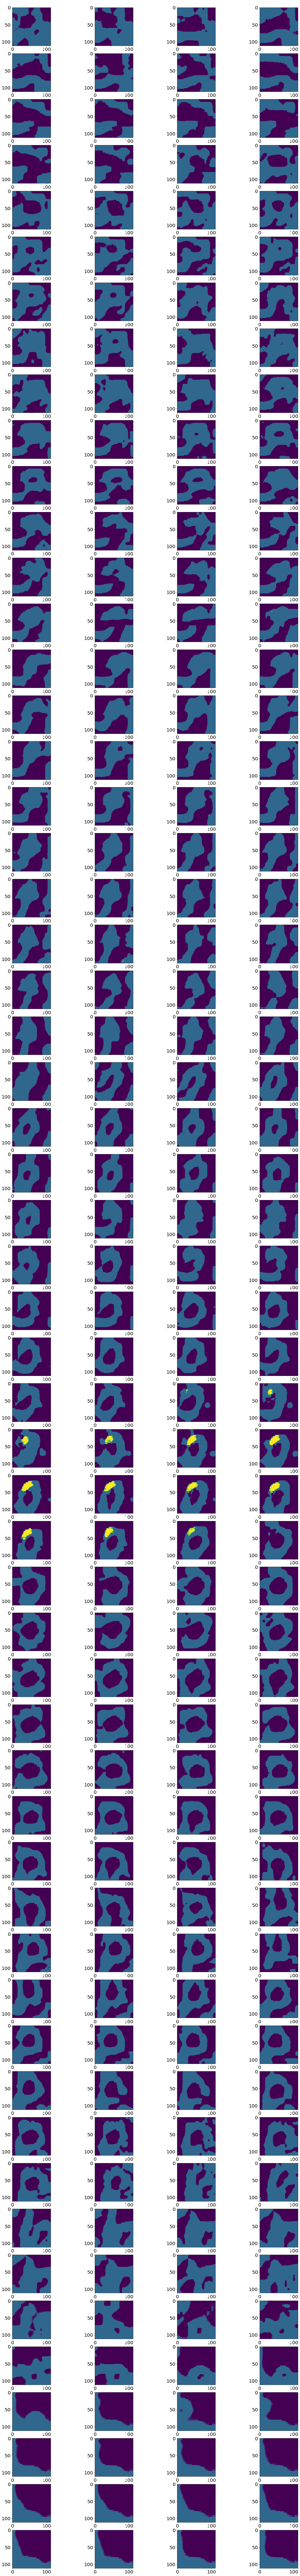

In [173]:
#------------------------------------------------
n_classes = 4
folder_name = 'model_unet_multi4_new_1_4class_Calc'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC_SR =  test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)
# def add_zeros(image):
#     image[0,0] = int(0)
#     image[0,1] = int(1)
#     image[1,0] = int(2)
#     image[1,1] = int(3)
#     return image

plot_CT_SR_seg([add_zeros(image) for image in seg_sr_images_MI_MC_SR] ,  datos, size = (24,200))

## Summary plot

In [164]:
name = 'plot_sfa006_error_7.png'
plot_complete_images(ct_im, sr_images, seg_sr_images_1input, seg_sr_images_multi_input, \
    seg_sr_images_MI_MC, seg_sr_images_MI_MC_SR, datos, name,  size = (24,750))

In [165]:
'Hugo_seg' in 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg'

True

# SFA001

In [17]:
path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
file = 'datos_info.xlsx'
error = 6
LB = 150
UB = 450
Lvalue = 0
Uvalue = 50
voisinage = 4
n_voisins = 2
norm_ALL = True
info_change = [voisinage, LB, UB, Lvalue, Uvalue, n_voisins]

dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA001'
sheet = 'SR_SFA0001_v3_test'
datos = pd.read_excel(os.path.join(path, file), sheet_name= sheet)

sr_images, ct_im = run_center_line(dirr, sheet, error, info_change, norm_ALL = norm_ALL)


520 389
Min Max all data set 3649 -856
Normalization wrt all data set
Min Max after normalization all data set 1.0 0.0


## UNET 1 input

In [18]:
n_classes = 3
folder_name = 'model_unet_1'
epoch_init = '100.torch'
multi = False
#------------------------------------------------
seg_sr_images_1input = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

1 INPUT


## UNET MULTI INPUT

In [19]:
#------------------------------------------------
n_classes = 3
folder_name = 'model_unet_multi_3'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_multi_input = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)


MULTI


In [20]:
#------------------------------------------------
n_classes = 5
folder_name = 'model_unet_multi_1_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


In [21]:
#------------------------------------------------
n_classes = 4
folder_name = 'model_unet_multi_5_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC_SR =  test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


## SUMMARY PLOT SFA001

In [22]:
name = 'plot_sfa001.png'
plot_complete_images(ct_im, sr_images, seg_sr_images_1input, seg_sr_images_multi_input, \
    seg_sr_images_MI_MC, seg_sr_images_MI_MC_SR, datos, name,  size = (24,750))

# SFA002

In [24]:
path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
file = 'datos_info.xlsx'
error = 6
LB = 150
UB = 450
Lvalue = 0
Uvalue = 50
voisinage = 4
n_voisins = 2
norm_ALL = True
info_change = [voisinage, LB, UB, Lvalue, Uvalue, n_voisins]

dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA002'
sheet = 'SR_SFA0002_v1'
datos = pd.read_excel(os.path.join(path, file), sheet_name= sheet)

sr_images, ct_im = run_center_line(dirr, sheet, error, info_change, norm_ALL = norm_ALL)


932 455
Min Max all data set 1788 -155
Normalization wrt all data set
Min Max after normalization all data set 1.0 0.0


## UNET 1 INPUT 

In [25]:
n_classes = 3
folder_name = 'model_unet_1'
epoch_init = '100.torch'
multi = False
#------------------------------------------------
seg_sr_images_1input = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

1 INPUT


## UNET MULTI INPUT

In [26]:
#------------------------------------------------
n_classes = 3
folder_name = 'model_unet_multi_3'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_multi_input = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)


MULTI


In [27]:
#------------------------------------------------
n_classes = 5
folder_name = 'model_unet_multi_1_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC = test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


In [28]:
#------------------------------------------------
n_classes = 4
folder_name = 'model_unet_multi_5_more_classes'
epoch_init = '100.torch'
multi = True
#------------------------------------------------
seg_sr_images_MI_MC_SR =  test_center_line(sr_images, multi, n_classes, folder_name, epoch_init)

MULTI


## SUMMARY PLOT 

In [29]:
name = 'plot_sfa002.png'
plot_complete_images(ct_im, sr_images, seg_sr_images_1input, seg_sr_images_multi_input, \
    seg_sr_images_MI_MC, seg_sr_images_MI_MC_SR, datos, name,  size = (24,750))

# THINGS TO REVIEW

In [ ]:
path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
file = 'datos_info.xlsx'
error = 6
norm_ALL_ = False

dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006'
sheet = 'SR_SFA0006_v1'
datos6 = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
# ct_im_sfa006, ct6, boxes6 = read_center_line(datos, error, dirr)
sr_images6, sr_images_w6, ct_im_sfa006, ct6 = run_center_line(dirr, sheet, error, norm_ALL = norm_ALL_)


In [ ]:
path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
file = 'datos_info.xlsx'
error = 6
norm_ALL_ = True

dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006'
sheet = 'SR_SFA0006_v1'
datos6 = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
# ct_im_sfa006, ct6, boxes6 = read_center_line(datos, error, dirr)
sr_images6, sr_images_w6, ct_im_sfa006, ct6 = run_center_line(dirr, sheet, error, norm_ALL = norm_ALL_)


In [ ]:
# # Saving images for training UNET with mask only with background
# # images without calcifications
# images = sr_images6
# images_NO_CALC = []
# for im in sr_images6[1:120]:
#     images_NO_CALC.append(np.stack((im)))
# #images_NO_CALC = np.array(images_NO_CALC)
# np.savez(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\ora_180919\Layers\train\SR_SFA006_images.npy', images_NO_CALC)
 

In [ ]:
# path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
# path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
# file = 'datos_info.xlsx'



# error = 6

# dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA001'
# sheet = 'SR_SFA0001_v3_test'
# datos1 = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
# #ct_im_sfa001, ct1, boxes1 = read_center_line(datos, error, dirr)
# sr_images1, sr_images_w1, ct_im_sfa001, ct1 = run_center_line(dirr, sheet, error, norm_ALL = False)

# #------------------------------------------------
# dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006'
# sheet = 'SR_SFA0006_v1'
# datos6 = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
# # ct_im_sfa006, ct6, boxes6 = read_center_line(datos, error, dirr)
# sr_images6, sr_images_w6, ct_im_sfa006, ct6 = run_center_line(dirr, sheet, error, norm_ALL = False)

# #------------------------------------------------
# dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA002'
# sheet = 'SR_SFA0002_v1'
# datos2 = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
# #ct_im_sfa002, ct2, boxes2 = read_center_line(datos, error, dirr)
# sr_images, sr_images_w, ct_im_sfa002, ct2 = run_center_line(dirr, sheet, error, norm_ALL = False)



In [ ]:
np.random.seed(19)

LB = 150
UB = 450
Lvalue = 0
Uvalue = 50
voisinage = 4
n_voisins = 2

index = 130
image = ct_im_sfa006[index]
plt.imshow(image)
plt.show()
image = change_values_CT_calc(image, voisinage, LB, UB, Lvalue, Uvalue, n_voisins)
plt.imshow(image)    



In [ ]:
ct_im_sfa006_new = []
for image in ct_im_sfa006:
    ct_im_sfa006_new.append(change_values_CT_calc(image, voisinage, LB, UB, Lvalue, Uvalue, n_voisins))


In [ ]:
# codigo aqui, debo incorporar la funcion anterior para la funcion run center line 

In [ ]:
norm_ALL = True
dirr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006'
sheet = 'SR_SFA0006_v1'
path  = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg'
path_sr = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\DATA_SFA006\super_resolution\LapSRN_x8.pb'
file = 'datos_info.xlsx'
datos6 = pd.read_excel(os.path.join(path, file), sheet_name= sheet)
#------------------------------------------------
ct_im = ct_im_sfa006_new
ct_im_norm = min_max_norm(ct_im)

if norm_ALL:
    sr_images = SR_CT(path_sr, ct_im_norm, normalization = False)
else:    
    sr_images = SR_CT(path_sr, ct_im, normalization = True)


In [ ]:
index  = 128
index_min = 100
print('Slice: ',datos6.Slice[index])
print(sr_images[index_min].min(), sr_images[index_min].max())
print(sr_images[index].min(), sr_images[index].max())


In [ ]:
# import seaborn as sns
# index  = 125
# channel = 1
# print(datos6.Slice[index])
# plt.imshow(ct6[index])
# plt.show()
# plt.imshow(sr_images6[index][:,:,channel])
# plt.show()
# plt.imshow(sr_images_w6[index][:,:,channel])
# plt.show()
# fig = plt.figure(figsize=(10,6))
# sns.kdeplot(sr_images6[index][:,:,channel].ravel(), color='blue')
# sns.kdeplot(sr_images6[index+1][:,:,channel].ravel(), color='red')
# sns.kdeplot(sr_images6[index+2][:,:,channel].ravel(), color='green')
# sns.kdeplot(sr_images6[index+3][:,:,channel].ravel(), color='yellow')
# sns.kdeplot(sr_images6[index+4][:,:,channel].ravel(), color='black')
# sns.kdeplot(sr_images6[index+5][:,:,channel].ravel(), color='violet')
# fig.legend(labels=['t','t+1','t+2', 't+3','t+4','t+5'])
# # plt.hist(sr_images6[index][:,:,channel].ravel())
# # plt.hist(sr_images6[index+1][:,:,channel].ravel())
# # plt.hist(sr_images6[index+2][:,:,channel].ravel())
# plt.show()
# fig = plt.figure(figsize=(10,6))
# sns.kdeplot(sr_images_w6[index][:,:,channel].ravel(), color='blue')
# sns.kdeplot(sr_images_w6[index+1][:,:,channel].ravel(), color='red')
# sns.kdeplot(sr_images_w6[index+2][:,:,channel].ravel(), color='green')
# sns.kdeplot(sr_images_w6[index+3][:,:,channel].ravel(), color='yellow')
# sns.kdeplot(sr_images_w6[index+4][:,:,channel].ravel(), color='black')
# sns.kdeplot(sr_images_w6[index+5][:,:,channel].ravel(), color='violet')
# fig.legend(labels=['t','t+1','t+2', 't+3','t+4','t+5'])

# # plt.hist(sr_images_w6[index][:,:,channel].ravel())
# # plt.hist(sr_images_w6[index+1][:,:,channel].ravel())
# # plt.hist(sr_images_w6[index+2][:,:,channel].ravel())
# plt.show()
# fig = plt.figure(figsize=(10,6))
# sns.kdeplot(ct6[index].ravel(), color='blue')
# sns.kdeplot(ct6[index+1].ravel(), color='red')
# sns.kdeplot(ct6[index+2].ravel(), color='green')
# sns.kdeplot(ct6[index+3].ravel(), color='yellow')
# sns.kdeplot(ct6[index+4].ravel(), color='black')
# sns.kdeplot(ct6[index+5].ravel(), color='violet')
# fig.legend(labels=['t','t+1','t+2', 't+3','t+4','t+5'])

# # plt.hist(ct6[index].ravel())
# # plt.hist(ct6[index+1].ravel())
# # plt.hist(ct6[index+2].ravel())
# plt.show()


In [ ]:

def plot_CT_values(SR_img, CT_img,  datos, size = (50,150)):
    fig = plt.figure(figsize=size)
    j = len(SR_img)//2
    k = 0
    h = 0
    channel = 0
    col = 'black'
    for i in range(k,k+j):
        ax  =  plt.subplots(j, 4, 4*h+1)
        ax.imshow(CT_img[2*i])
        ax.set_title(" SR CT  "+str(datos['Slice'][2*i]))
        for l in range(CT_img[2*i].shape[0]):
            for m in range(CT_img[2*i].shape[1]):
                text = ax.text(m, l, CT_img[2*i][l, m],
                            ha="center", va="center", color=col)
        
        ax  =  plt.subplots(j, 4, 4*h+2)
        ax.imshow(SR_img[2*i][:,:,channel])
        ax.set_title(" SR CT  "+str(datos['Slice'][2*i]))
        for l in range(SR_img[2*i][:,:,channel].shape[0]):
            for m in range(SR_img[2*i][:,:,channel].shape[1]):
                text = ax.text(m, l, SR_img[2*i][:,:,channel][l, m],
                            ha="center", va="center", color=col)


        ax  =  plt.subplots(j, 4, 4*h+3)
        ax.imshow(CT_img[2*i+1])
        ax.set_title(" CT  "+str(datos['Slice'][2*i+1]))
        for l in range(CT_img[2+1].shape[0]):
            for m in range(CT_img[2*i+1].shape[1]):
                text = ax.text(m, l, CT_img[2*i+1][l, m],
                            ha="center", va="center", color=col)
                            
        ax  =  plt.subplots(j, 4, 4*h+4)
        ax.imshow(SR_img[2*i+1][:,:,channel])
        ax.set_title("SR CT  "+str(datos['Slice'][2*i+1]))
        for l in range(SR_img[2*i+1][:,:,channel].shape[0]):
            for m in range(SR_img[2*i+1][:,:,channel].shape[1]):
                text = ax.text(m, l, SR_img[2*i+1][:,:,channel][l, m],
                            ha="center", va="center", color=col)
                            
        h +=1


In [ ]:
def plot_CT_values(CT_img,  datos, size = (50,150)):
    j = len(CT_img)//4
    print(j)
    channel = 0
    col = 'black'
    Cmap = 'gray'
    fig, ax  =  plt.subplots(j, 4, figsize=size)
    
    for i in range(j):
        ax[i, 0].imshow(CT_img[4*i], cmap = Cmap)
        ax[i, 0].set_title(" CT  "+str(datos['Slice'][4*i]), color = 'white')
        for l in range(CT_img[4*i].shape[0]):
            for m in range(CT_img[4*i].shape[1]):
                text = ax[i,0].text(m, l, CT_img[4*i][l, m],
                            ha="center", va="center", color=col)
        

        ax[i, 1].imshow(CT_img[4*i+1],cmap = Cmap)
        ax[i, 1].set_title(" CT  "+str(datos['Slice'][4*i+1]),  color = 'white')
        for l in range(CT_img[4*i+1].shape[0]):
            for m in range(CT_img[4*i+1].shape[1]):
                text = ax[i, 1].text(m, l, CT_img[4*i+1][l, m],
                            ha="center", va="center", color=col)


        ax[i, 2].imshow(CT_img[4*i+2], cmap = Cmap)
        ax[i, 2].set_title(" CT  "+str(datos['Slice'][4*i+2]), color = 'white')
        for l in range(CT_img[2+1].shape[0]):
            for m in range(CT_img[4*i+2].shape[1]):
                text = ax[i, 2].text(m, l, CT_img[4*i+2][l, m],
                            ha="center", va="center", color=col)
                            
        ax[i, 3].imshow(CT_img[4*i+3], cmap = Cmap)
        ax[i, 3].set_title(" CT  "+str(datos['Slice'][4*i+3]), color = 'white')
        for l in range(CT_img[4*i+3].shape[0]):
            for m in range(CT_img[4*i+3].shape[1]):
                text = ax[i, 3].text(m, l, CT_img[4*i+3][l, m],
                            ha="center", va="center", color=col)
                            


In [ ]:
# import matplotlib
# matplotlib.rcParams.update({'font.size': 14})
# size = 10
# plot_CT_values(ct_im_sfa006,  datos6, (size*4,size*70))#size = (30,80)

In [ ]:
size = 15
plot_CT_values(ct_im_sfa002[116:145],  datos2.loc[116:145].reset_index(), (size*4,size*7))#size = (30,80)

In [ ]:
size = 15
plot_CT_values(ct_im_sfa001[100:133],  datos1.loc[100:133].reset_index(), (size*4,size*8))#size = (30,80)

In [ ]:

def plot_SR_values(SR_img,  datos, size = (50,150)):
    j = len(SR_img)//2
    print(j)
    channel = 0
    col = 'black'
    fig, ax  =  plt.subplots(j, 2, figsize=size)
    
    for i in range(j):
        ax[i, 0].imshow(SR_img[2*i][:,:,channel])
        ax[i, 0].set_title(" SR CT  "+str(datos['Slice'][2*i]))
        for l in range(SR_img[2*i][:,:,channel].shape[0]):
            for m in range(SR_img[2*i][:,:,channel].shape[1]):
                text = ax[i, 0].text(m, l, str(np.round(SR_img[2*i][:,:,channel][l, m], 2)),
                            ha="center", va="center", color=col)

        ax[i, 1].imshow(SR_img[2*i+1][:,:,channel])
        ax[i, 1].set_title("SR CT  "+str(datos['Slice'][2*i+1]))
        for l in range(SR_img[2*i+1][:,:,channel].shape[0]):
            for m in range(SR_img[2*i+1][:,:,channel].shape[1]):
                text = ax[i, 1].text(m, l,str(np.round(SR_img[2*i+1][:,:,channel][l, m], 2)),
                            ha="center", va="center", color=col)


In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

index = 133
image = sr_images6[index][:,:,channel][10:55, 15:65]
# plt.imshow(image)
channel = 0



fig, ax =  plt.subplots(figsize=(30,30))
ax.imshow(image)
print('Slice: ',datos6.Slice[index])
# Loop over data dimensions and create text annotations.
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        text = ax.text(j, i, np.round(image[i, j], 2),
                       ha="center", va="center", color="black")


In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

index = 114
image = sr_images6[index][:,:,channel][10:55, 15:65]
# plt.imshow(image)
channel = 0


print('Slice: ',datos6.Slice[index])
fig, ax =  plt.subplots(figsize=(30,30))
ax.imshow(image)

# Loop over data dimensions and create text annotations.
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        text = ax.text(j, i, np.round(image[i, j], 2),
                       ha="center", va="center", color="black")


In [ ]:
# plot_SR_segmentations(sr_images6, datos6)

In [ ]:
calc = np.where((datos6.Slice>=1484) & (datos6.Slice<=1497))[0]
no_calc = np.where((datos6.Slice<1484) | (datos6.Slice>1497))[0]

sfa6_no_calc = []
sfa6_calc = []
sfa1 = []
sfa2 = []

for image in ct_im_sfa001:
    sfa1 += list(image.ravel())
for image in ct_im_sfa002:
    sfa2 += list(image.ravel())

for index in calc:
    sfa6_calc += list(ct_im_sfa006[index].ravel())

for index in no_calc:
    sfa6_no_calc += list(ct_im_sfa006[index].ravel())


In [ ]:
print(np.min(sfa1), np.max(sfa1))
print(np.min(sfa2), np.max(sfa2))
print(np.min(sfa6_calc), np.max(sfa6_calc))
print(np.min(sfa6_no_calc), np.max(sfa6_no_calc))

In [ ]:

Bins = 30

from matplotlib.pyplot import figure

figure(figsize=(15, 8), dpi=80)

# weights=np.ones_like(sfa6_calc) / len(sfa6_calc)
# weights = np.ones_like(sfa6_no_calc) / len(sfa6_no_calc)
# plt.hist(sfa6_calc, bins = Bins, color='red', density=True, \
#     alpha = 0.8, lw=3, label ='SFA006 With Calc.')
# plt.hist(sfa6_no_calc,bins = Bins,  alpha = 0.6, lw=3, color='blue', \
#     density=True, label ='SFA006  Without Calc')
# plt.hist(sfa1,bins = Bins,  alpha = 0.4, lw=3, color='green', \
#     density=True, label ='SFA001')
# plt.hist(sfa2,bins = Bins,  alpha = 0.5, lw=3, color='yellow', \
#     density=True, label ='SFA002')
sns.kdeplot(sfa6_calc,  color='red', label ='SFA006 With Calc.', shade=True)
#sns.kdeplot(sfa6_no_calc, color='blue', label ='SFA006  Without Calc', shade=True)
sns.kdeplot(sfa1,  color='green', label ='SFA001', shade=True)
sns.kdeplot(sfa2, color='yellow', label ='SFA002', shade=True)
plt.legend()
plt.title('Density plot')
plt.xlabel('pixel values')
plt.xlim(-250, 1500)
# plt.ylim(0, 0.02)
plt.show()

In [ ]:
sns.kdeplot(sfa6_calc,  color='blue', label= 'SFA001')
sns.kdeplot(sfa6_no_calc, color='red')
plt.legend()
plt.show()

In [ ]:
print(np.min(sfa1), np.max(sfa1))
print(np.min(sfa2), np.max(sfa2))
print(np.min(sfa6_calc), np.max(sfa6_calc))
print(np.min(sfa6_no_calc), np.max(sfa6_no_calc))

limites = np.arange(-200,500,50)
limites = np.append(limites, 4000)
limites = np.insert(limites, 0, -1000)
# count_sfa6 = pd.DataFrame()
# count_sfa6['No calc'] =  
df = pd.Series(pd.cut(sfa6_calc, bins = limites)).value_counts(normalize= True).round(4).multiply(100).reset_index(name='SFA006 images with calc')
df = df.merge(pd.Series(pd.cut(sfa6_no_calc, bins = limites)).value_counts(normalize= True).round(4).multiply(100).reset_index(name='SFA006 images without calc'), on='index').sort_values('index')
df = df.merge(pd.Series(pd.cut(sfa1, bins = limites)).value_counts(normalize= True).round(4).multiply(100).reset_index(name='SFA001 all images'), on='index').sort_values('index')
df = df.merge(pd.Series(pd.cut(sfa2, bins = limites)).value_counts(normalize= True).round(4).multiply(100).reset_index(name='SFA002 all images'), on='index').sort_values('index')
df = df.rename(columns = {'index':'Interval_pixel_values'})
df


In [ ]:

pd.Series(pd.cut(sfa6_calc, bins = limites))

In [ ]:

plt.hist((all_pixels_sfa002  - np.min(all_pixels_sfa002 ))/(np.max(all_pixels_sfa002 ) - np.min(all_pixels_sfa002 )), bins = 100)
plt.hist((all_pixels_sfa006  - np.min(all_pixels_sfa006 ))/(np.max(all_pixels_sfa006 ) - np.min(all_pixels_sfa006 )), bins = 100)
plt.hist((all_pixels_sfa001  - np.min(all_pixels_sfa001 ))/(np.max(all_pixels_sfa001 ) - np.min(all_pixels_sfa001 )), bins = 100)

plt.show()


In [ ]:
import seaborn as sns
#sns.set_style('whitegrid')
sns.kdeplot(all_pixels_sfa001, color='blue')
sns.kdeplot(all_pixels_sfa006, color='red')
plt.xlim(-350, 700)
#sns.kdeplot(all_pixels_sfa002, color='green')

In [ ]:
plt.hist(all_pixels_sfa002 , bins = 100)
plt.hist(all_pixels_sfa006 , bins = 100)
plt.hist(all_pixels_sfa001 , bins = 100)
plt.show()

In [ ]:

plt.hist(all_pixels_sfa006 , bins = 200)
plt.hist(all_pixels_sfa001 , bins = 200)
plt.xlim(-250, 500)
plt.show()

In [ ]:
plt.hist(all_pixels_sfa002 , bins = 100)
plt.show()
plt.hist(all_pixels_sfa006 , bins = 100)
plt.show()
plt.hist(all_pixels_sfa001 , bins = 100)
plt.show()

In [ ]:
def plot_SR_segmentations(seg_sr_images, datos, size = (25,125)):
    fig = plt.figure(figsize=size)
    j = len(seg_sr_images)//6
    k = 0
    h = 0
    for i in range(k,k+j):
        ax  =  plt.subplot(j, 6, 6*h+1)
        ax.imshow(seg_sr_images[6*i])
        ax.set_title(" CT  "+str(datos['Slice'][6*i]))
        
        ax  =  plt.subplot(j, 6, 6*h+2)
        ax.imshow(seg_sr_images[6*i+1])
        ax.set_title("CT  "+str(datos['Slice'][6*i+1]))
        
        ax  =  plt.subplot(j, 6, 6*h+3)
        ax.imshow(seg_sr_images[6*i+2])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+2]))
        
        ax  =  plt.subplot(j, 6, 6*h+4)
        ax.imshow(seg_sr_images[6*i+3])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+3]))  

        ax  =  plt.subplot(j, 6, 6*h+5)
        ax.imshow(seg_sr_images[6*i+4])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+4]))  

        ax  =  plt.subplot(j, 6, 6*h+6)
        ax.imshow(seg_sr_images[6*i+5])
        ax.set_title(" CT  "+str(datos['Slice'][6*i+5]))   
        h +=1
    


## SFA001

In [ ]:
plot_SR_segmentations(ct_im_sfa001, datos)

## SFA002

In [ ]:
plot_SR_segmentations(ct_im_sfa002, datos,  size = (25,185))

## SFA006

In [ ]:
plot_SR_segmentations(ct_im_sfa006, datos)